In [ ]:
from typing import Union, Tuple

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Data is previously retrieved from https://www.kaggle.com/datasets/CooperUnion/cardataset
DATA_PATH = '../data/data.csv'

In [87]:
def standardise_strings(
    target: Union[pd.core.strings.accessor.StringMethods, pd.core.indexes.base.Index]
) -> Union[pd.core.series.Series, pd.core.indexes.base.Index]:
    """
        Stage 1 cleaning for this price prediction:
        - Lower case for everything
        - Spaces replaced by underscores

        Can work on either Pandas indices (e.g. column headers) or Pandas series (e.g. row data)
        
        :param StringMethods | Index target: the target row or column to standardise
        :return StringMethods | Index result: the standardised row or column

        Note the return types are using typing since this was written pre-3.10.
    """
    result = (
        target
        .str
        .lower()
        .str
        .replace(' ', '_')
    )

    return result

def train_test_val_split(
    df_data: pd.DataFrame,
    validation_split: float=0.2,
    testing_split: float=0.2,
    shuffle_seed:int = 2
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
        Stage 2: Validation framework for this price prediction:
        - Source data shuffled with numpy
        - Split into validation/test sets in specified ratios
        - The remainder reserved for training.

        :param pd.DataFrame df_data: dataset to split
        :param float validation_split: ratio to split source data into a validation set: 20% by default
        :param float testing_split: ratio to split source data into a testing set: 20% by default
        :param int shuffle_seed: random seed for shuffling - default is 2

        :return Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame] df_train, df_val, df_test: all dataframes shuffled and split in their specific ratios.

        Note the return types are using typing since this was written pre-3.10.
    """
    n = len(df_data)
    n_val = int(n * validation_split)
    n_test = int(n * testing_split)
    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.seed(shuffle_seed)
    np.random.shuffle(idx)

    df_train = df_data.iloc[idx[:n_train]]
    df_val = df_data.iloc[idx[n_train:n_val + n_train]]
    df_test = df_data.iloc[idx[n_train + n_val:]]

    return df_train, df_val, df_test

def regression_setup(
    df_data: pd.DataFrame, 
    label: str
) -> Tuple[pd.DataFrame, np.ndarray]:
    """
        Stage 3: Extract y-value from the different train/test/val datasets
        The following is done to the source dataframe:
        - Index dropped
        - Y-value extracted to its own numpy array and returned
        - The column used for y-value is deleted from the source dataframe - the modified dataframe is also returned

        :param pd.DataFrame df_data: dataset to use
        :param str label: Desired y-value

        :return Tuple[pd.DataFrame, np.ndarray] df_data, y_data: dataframe with label removed, plus the label data in separate array

        Note the return types are using typing since this was written pre-3.10.
    """
    # Indexes not necessary - so drop them
    df_data = df_data.reset_index(drop=True)

    # Grab the label/y-value as a separate numpy array
    y_data = np.log1p(df_data[label].values)

    # Get rid of the y-value from the datasets so they don't accidentally get used as features...
    del df_data[label]

    return df_data, y_data    

def summary_printout(
    df: pd.DataFrame, 
    col: str
):
    """
        Summary printout for a Pandas dataframe column.

        :param pd.DataFrame df: The source dataframe
        :param str col: The column name

        No returns.
    """
    print(f"Summary printout for {col}")
    print(f"Total unique values: {df[col].nunique()}")
    print(f"Sample: {df[col].unique()[:5]}")    

In [ ]:
df_cars = pd.read_csv(DATA_PATH)
df_cars.head()

In [ ]:
# Stage 1 Cleaning on both column headers and values.
df_cars.columns = standardise_strings(df_cars.columns)
df_cars.columns

# Original code: df.dtypes == 'object' - not a fan.
# Get rid of magic strings and filters using those :)
object_filter = df_cars.dtypes == type(object)

# This is then used to do the same column conversions as before
string_cols = list(df_cars.dtypes[object_filter].index)

for next_col in string_cols:
    df_cars[next_col] = standardise_strings(df_cars[next_col])

df_cars.head()

In [ ]:
for next_col in df_cars.columns:
    summary_printout(df=df_cars, col=next_col)

### First chart

We are expecting a long-tail distribution for this dataset - some cars will be very expensive (e.g. up to $2m) and will make the initial graph look skewed.

In [ ]:
# First graph to show everything
sns.histplot(df_cars.msrp, bins=50)

In [ ]:
# Second graph to show a better view of the distribution
# There are still a very large number of cars with $1000 price though
filter = df_cars.msrp < 100000
sns.histplot(df_cars.msrp[filter], bins=50)

In [ ]:
# Turn prices into logarithmic values (np.log1p so divide by zero error doesn't occur)
# The resulting graph is closer to a normal distribution - despite the weird $1000 values (indicates this may be the minimum price to list)
log_price = np.log1p(df_cars.msrp)
sns.histplot(log_price, bins=50)

### Validation framework

In [ ]:
df_cars_train, df_cars_val, df_cars_test = train_test_val_split(df_data=df_cars, validation_split=0.2, testing_split=0.2, shuffle_seed=2)

In [ ]:
# Set up labels for each dataset
Y_VAL_LABEL = 'msrp'

df_cars_train, y_cars_train = regression_setup(df_cars_train, Y_VAL_LABEL)
df_cars_val, y_cars_val = regression_setup(df_cars_val, Y_VAL_LABEL)
df_cars_test, y_cars_test = regression_setup(df_cars_test, Y_VAL_LABEL)

### Linear Regression Training

#### Vector-Based Regression Formula Example
$g(x_i) = W_0 + W_1 \cdot x_{i1} + W_2 \cdot x_{i2} ... W_n \cdot x_{in}$

This can also be written as:  
  
$g(x_i) = W_0 + \sum_{j=1}^n W_j \cdot x_{ij}$  
  
or in our case, with 3 features selected:  
  
$g(x_i) = W_0 + \sum_{j=1}^3 W_j \cdot x_{ij}$  

But when all records are included, this can be simplified as:
$g(X) = X \cdot y$ where $X$ is a feature matrix, and y is a vector of weights.

So long as $W_0$ is integrated into the rest of the weights, and $x_0$ is 1.

In [106]:
def linear_regression(
    X: np.ndarray,
    w: list
) -> np.ndarray:
    
    prediction = X.dot(w)

    return prediction

In [107]:
x1 = [1, 148, 24, 1385]
x2 = [1, 132, 25, 2031]
x10 = [1, 453, 11, 86]
w = [7.17, 0.01, 0.04, 0.002]

X = [x1, x2, x10]
X = np.array(X)

# Reverse the log1p done on the MSRP in a previous step to get the "real" MSRP value
np.expm1(linear_regression(X, w))

array([12.38 , 13.552, 12.312])

#### Normal Regression Formula

The above vector formula was using hard-coded weights. Later, the Zoomcamp goes into deriving these ourselves.

This needs to be approximated with something called a **Gram matrix**:

$X \cdot X^T$ where $X^T$ is the feature matrix transposed.

This results in the final equation:

$w = (X^TX)^{-1} X^Ty$

In [ ]:
def train_linear_regression(
    X: np.ndarray, 
    y: np.ndarray) -> Tuple[float, np.ndarray]:

    """
        Trains a linear regression model per the "normal" regression formula above.
        
        :param np.ndarray X: matrix of the features
        :param np.ndarray y: matrix of the values/labels

        :return Tuple[float, np.ndarray] - the bias weight + all the others

        Note the return types are using typing since this was written pre-3.10.    
    """

    # Add 1s
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # Normal equation with transposed X
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [144]:
def prepare_X(
    features: list,
    df_data: pd.DataFrame
) -> np.ndarray:
    df_features = df_data[features].fillna(0)
    X = df_features.values
    return X

In [146]:
features_base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# Training
X_cars_train = prepare_X(features_base, df_cars_train)
# Already have y_cars_train earlier from the cleaning stage

w0, w = train_linear_regression(X_cars_train, y_cars_train)
y_cars_pred = w0 + X_cars_train.dot(w)

rmse(y_cars_train, y_cars_pred)

0.7554192603920132

#### Comparing initial model vs. actual values

It's a bit off.

<AxesSubplot: ylabel='Count'>

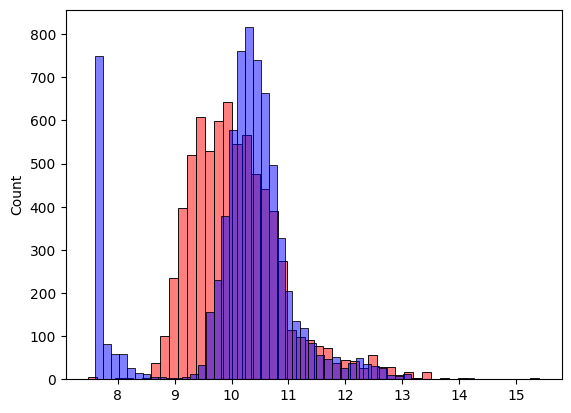

In [136]:
sns.histplot(y_cars_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_cars_train, color='blue', alpha=0.5, bins=50)

#### Using RMSE to figure things out

RMSE = "Root Mean Squared Error"

In [143]:
def rmse(
    y: np.ndarray, 
    y_pred: np.ndarray
) -> np.float64:
    squared_error = (y - y_pred) ** 2
    mean_squared_error = squared_error.mean()
    root_mean_squared_error = np.sqrt(mean_squared_error)
    return root_mean_squared_error

0.7554192603920132

In [145]:
features_base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# Training
X_cars_train = prepare_X(features_base, df_cars_train)
# Already have y_cars_train earlier from the cleaning stage

w0, w = train_linear_regression(X_cars_train, y_cars_train)
y_cars_pred = w0 + X_cars_train.dot(w)

# Validation
X_cars_val = prepare_X(features_base, df_cars_val)
y_cars_val_pred = w0 + X_cars_val.dot(w)

rmse(y_cars_val, y_cars_val_pred)

0.761653099130156